# LOGOTS
Transformation layer notebook

In [105]:
import pandas as pd
import numpy as np
from scipy.fftpack import fft, fftfreq
import time
import ast
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.signal import spectrogram

In [106]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Transformation Layer

## Audio

In [136]:
stg_audio_data = pd.read_csv("stg_audio_data.csv")

In [137]:
# Convert `audio_samples` column from string to list
stg_audio_data['audio_samples'] = stg_audio_data['audio_samples'].apply(ast.literal_eval)

In [138]:
stg_audio_data.head(10)

,frame_id,timestamp,audio_samples
0,0,2025-10-04 11:08:56.774827,"[-988, -988, -1235, -1235, -1630, -1630, -1778..."
1,1,2025-10-04 11:08:56.964901,"[-197, -197, -395, -395, -592, -592, -395, -39..."
2,2,2025-10-04 11:08:57.074083,"[-1778, -1778, -2223, -2223, -2371, -2371, -15..."
3,3,2025-10-04 11:08:57.203379,"[-49, -49, -247, -247, 197, 197, 592, 592, 938..."
4,4,2025-10-04 11:08:57.377462,"[543, 543, -197, -197, -642, -642, -988, -988,..."
5,5,2025-10-04 11:08:57.556101,"[-197, -197, 345, 345, 395, 395, 197, 197, -19..."
6,6,2025-10-04 11:08:57.680016,"[2173, 2173, 1926, 1926, 1729, 1729, 1581, 158..."
7,7,2025-10-04 11:08:57.838585,"[345, 345, 197, 197, -197, -197, -197, -197, -..."
8,8,2025-10-04 11:08:58.062314,"[148, 148, -395, -395, -1630, -1630, -1383, -1..."
9,9,2025-10-04 11:08:58.310684,"[1729, 1729, 2173, 2173, 1926, 1926, 1333, 133..."


In [139]:
def compute_fft(samples, sampling_rate=16000):
    """
    Computes the FFT for the given audio samples.

    Parameters:
        samples (list or np.array): Audio samples.
        sampling_rate (int): Sampling rate of the audio.

    Returns:
        dict: A dictionary with 'freqs' and 'magnitudes'.
    """
    samples = np.array(samples)
    n = len(samples)
    freqs = np.fft.rfftfreq(n, d=1/sampling_rate)
    fft_values = np.abs(np.fft.rfft(samples))
    return {"freqs": freqs, "magnitudes": fft_values}

def classify_voice_or_noise(freqs, magnitudes, voice_freq_range=(500, 3500), energy_threshold=15000000):
    """
    Classifies whether the given frequencies and magnitudes represent a voice or noise.

    Parameters:
        freqs (list or np.array): Frequencies from the FFT.
        magnitudes (list or np.array): Corresponding magnitudes for the frequencies.
        voice_freq_range (tuple): The frequency range considered as 'voice'. Default is (85, 255) Hz.
        energy_threshold (float): The minimum energy (sum of magnitudes in the range) to classify as voice.

    Returns:
        str: 'Voice' if the input is classified as voice, 'Noise' otherwise.
    """
    # Convert to numpy arrays for efficient computation
    freqs = np.array(freqs)
    magnitudes = np.array(magnitudes)

    # Find indices within the voice frequency range
    voice_indices = (freqs >= voice_freq_range[0]) & (freqs <= voice_freq_range[1])

    # Calculate total energy in the voice frequency range
    voice_energy = np.sum(magnitudes[voice_indices])

    # Classify based on energy threshold
    if voice_energy > energy_threshold:
        return "Voice"
    else:
        return "Noise"
        

def detect_cat_voice(classification, freqs, magnitudes, freq_range=(400, 700), harmonic_range=(200, 1000), harmonic_threshold=15):
    """
    Determines if the detected voice is a cat's voice based on spectral peaks and harmonic energy.

    Parameters:
        classification (str): The classification ('Voice' or 'Noise').
        freqs (list or np.array): Frequencies from the FFT result.
        magnitudes (list or np.array): Magnitudes corresponding to the frequencies.
        freq_range (tuple): Frequency range for a cat's voice.
        harmonic_range (tuple): Frequency range for detecting harmonics.
        harmonic_threshold (float): Ratio of harmonic energy to primary peak magnitude to classify as human.

    Returns:
        int: 1 if the detected voice is a cat's voice, 0 otherwise.
    """
    if classification != "Voice":
        return 0

    # Convert to numpy arrays for efficient computation
    freqs = np.array(freqs)
    magnitudes = np.array(magnitudes)

    # Select frequencies and magnitudes within the primary range (cat voice range)
    primary_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
    primary_freqs = freqs[primary_mask]
    primary_magnitudes = magnitudes[primary_mask]

    if len(primary_freqs) == 0 or len(primary_magnitudes) == 0:
        return 0  # No energy in the cat's voice range

    # Find the primary peak (highest magnitude in the primary range)
    primary_peak_magnitude = primary_magnitudes.max()

    # Check for harmonics in the harmonic range
    harmonic_mask = (freqs >= harmonic_range[0]) & (freqs <= harmonic_range[1])
    harmonic_magnitudes = magnitudes[harmonic_mask]

    # Calculate total harmonic energy
    harmonic_energy = np.sum(harmonic_magnitudes)

    # Classify as a cat's voice if harmonic energy is low relative to the primary peak
    if harmonic_energy / primary_peak_magnitude < harmonic_threshold:
        return 1  # Cat's voice detected

    return 0  # Not a cat's voice

def detect_human_voice(classification, freqs, magnitudes, freq_range=(150, 600), harmonic_range=(2000, 4000), harmonic_threshold=15):
    """
    Determines if the detected voice is a human's voice based on normalized average of squared magnitudes
    and harmonic energy analysis.

    Parameters:
        classification (str): The classification ('Voice' or 'Noise').
        freqs (list or np.array): Frequencies from the FFT result.
        magnitudes (list or np.array): Magnitudes corresponding to the frequencies.
        freq_range (tuple): Frequency range for a human's voice.
        harmonic_range (tuple): Frequency range to detect harmonic energy for human voices.
        harmonic_threshold (float): Threshold for detecting significant harmonic energy.

    Returns:
        int: 1 if the detected voice is a human's voice, 0 otherwise.
    """
    if classification != "Voice":
        return 0

    # Convert to numpy arrays for efficient computation
    freqs = np.array(freqs)
    magnitudes = np.array(magnitudes)

    # Select frequencies and magnitudes within the primary human voice range
    primary_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
    primary_magnitudes = magnitudes[primary_mask]

    if len(primary_magnitudes) == 0:
        return 0

    # Calculate normalized average squared magnitude within the primary range
    primary_energy = np.mean(primary_magnitudes**2) / np.max(magnitudes**2)

    # Select frequencies and magnitudes within the harmonic range
    harmonic_mask = (freqs >= harmonic_range[0]) & (freqs <= harmonic_range[1])
    harmonic_magnitudes = magnitudes[harmonic_mask]

    if len(harmonic_magnitudes) == 0:
        return 0

    # Calculate total harmonic energy
    harmonic_energy = np.sum(harmonic_magnitudes)

    # Detect human voice if primary energy and harmonic energy exceed thresholds
    if primary_energy > 0.1 and harmonic_energy > harmonic_threshold:
        return 1

    return 0

def calculate_meow_loudness(is_cat_voice, magnitudes):
    """
    Buckets the loudness of a meow into 'low', 'medium', or 'high' if is_cat_voice is True.

    Parameters:
        is_cat_voice (int): 1 if it's a cat's voice, 0 otherwise.
        magnitudes (list): Magnitudes corresponding to the FFT result.

    Returns:
        str: 'low', 'medium', or 'high' if is_cat_voice is True; 'none' otherwise.
    """
    if is_cat_voice != 1:
        return "none"  # Not a cat's voice
    
    # Calculate the average loudness from magnitudes
    avg_loudness = np.mean(magnitudes)

    # Define thresholds for loudness buckets
    if avg_loudness < 40000:  # Threshold for low loudness
        return "low"
    elif 40000 <= avg_loudness <= 60000:  # Threshold for medium loudness
        return "medium"
    else:  # Threshold for high loudness
        return "high"

def calculate_dominant_frequency(freqs, magnitudes):
    """
    Calculates the dominant frequency from the FFT results.

    Parameters:
        freqs (list or array): List or array of frequencies from the FFT result.
        magnitudes (list or array): Corresponding magnitudes for the frequencies.

    Returns:
        float: The frequency with the highest magnitude.
    """
    # Check if freqs or magnitudes are empty
    if freqs.size == 0 or magnitudes.size == 0:
        return 0  # Return 0 if no frequencies or magnitudes are present

    # Find the index of the maximum magnitude
    max_index = np.argmax(magnitudes)

    # Return the frequency corresponding to the max magnitude
    return freqs[max_index]

In [140]:
# Timing function
def measure_time(func, *args, **kwargs):
    """
    Measures the execution time of a function.

    Parameters:
        func (callable): Function to be executed.
        *args: Positional arguments for the function.
        **kwargs: Keyword arguments for the function.

    Returns:
        tuple: (result, execution_time_in_seconds)
    """
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    return result, end_time - start_time

In [141]:
trans_audio_features = stg_audio_data[['frame_id', 'timestamp']]

In [142]:
# 1. Compute FFT and time it
trans_audio_features["fft_result"], fft_time = measure_time(
    lambda: stg_audio_data["audio_samples"].apply(compute_fft)
)
print(f"FFT computation time: {fft_time:.6f} seconds")

# 2. Classify voice or noise and time it
trans_audio_features["classification"], classification_time = measure_time(
    lambda: trans_audio_features["fft_result"].apply(
        lambda x: classify_voice_or_noise(x["freqs"], x["magnitudes"])
    )
)
print(f"Voice/Noise classification time: {classification_time:.6f} seconds")

# 3. Detect cat voice and time it
trans_audio_features["is_cat_voice"], cat_voice_time = measure_time(
    lambda: trans_audio_features.apply(
        lambda row: detect_cat_voice(
            row["classification"], row["fft_result"]["freqs"], row["fft_result"]["magnitudes"]
        ),
        axis=1
    )
)
print(f"Cat voice detection time: {cat_voice_time:.6f} seconds")

# 4. Detect human voice and time it
trans_audio_features["is_human_voice"], human_voice_time = measure_time(
    lambda: trans_audio_features.apply(
        lambda row: detect_human_voice(
            row["classification"], row["fft_result"]["freqs"], row["fft_result"]["magnitudes"]
        ),
        axis=1
    )
)
print(f"Human voice detection time: {human_voice_time:.6f} seconds")

# 5. Calculate meow loudness and time it
trans_audio_features["meow_loudness"], meow_loudness_time = measure_time(
    lambda: trans_audio_features.apply(
        lambda row: calculate_meow_loudness(
            row["is_cat_voice"], row["fft_result"]["magnitudes"]
        ),
        axis=1
    )
)
print(f"Meow loudness calculation time: {meow_loudness_time:.6f} seconds")

# 6. Calculate dominant frequency and time it
trans_audio_features["dominant_frequency"], dominant_frequency_time = measure_time(
    lambda: trans_audio_features["fft_result"].apply(
        lambda x: calculate_dominant_frequency(x["freqs"], x["magnitudes"])
    )
)
print(f"Dominant frequency calculation time: {dominant_frequency_time:.6f} seconds")

FFT computation time: 0.027075 seconds
Voice/Noise classification time: 0.001157 seconds
Cat voice detection time: 0.001293 seconds
Human voice detection time: 0.001525 seconds
Meow loudness calculation time: 0.000471 seconds
Dominant frequency calculation time: 0.000232 seconds


In [143]:
trans_audio_features.tail(50)

,frame_id,timestamp,fft_result,classification,is_cat_voice,is_human_voice,meow_loudness,dominant_frequency
30,30,2025-10-04 11:09:03.581285,"{'freqs': [0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24...",Noise,0,0,none,48.0
31,31,2025-10-04 11:09:03.881312,"{'freqs': [0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24...",Noise,0,0,none,100.0
32,32,2025-10-04 11:09:04.059642,"{'freqs': [0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24...",Voice,1,0,low,624.0
33,33,2025-10-04 11:09:04.259526,"{'freqs': [0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24...",Voice,0,0,none,2212.0
34,34,2025-10-04 11:09:04.460643,"{'freqs': [0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24...",Voice,0,0,none,1460.0
35,35,2025-10-04 11:09:04.739847,"{'freqs': [0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24...",Voice,0,0,none,28.0
36,36,2025-10-04 11:09:04.989703,"{'freqs': [0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24...",Noise,0,0,none,28.0
37,37,2025-10-04 11:09:05.272789,"{'freqs': [0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24...",Noise,0,0,none,24.0
38,38,2025-10-04 11:09:05.488703,"{'freqs': [0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24...",Noise,0,0,none,24.0
39,39,2025-10-04 11:09:05.780716,"{'freqs': [0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24...",Noise,0,0,none,100.0


### Visualize Data

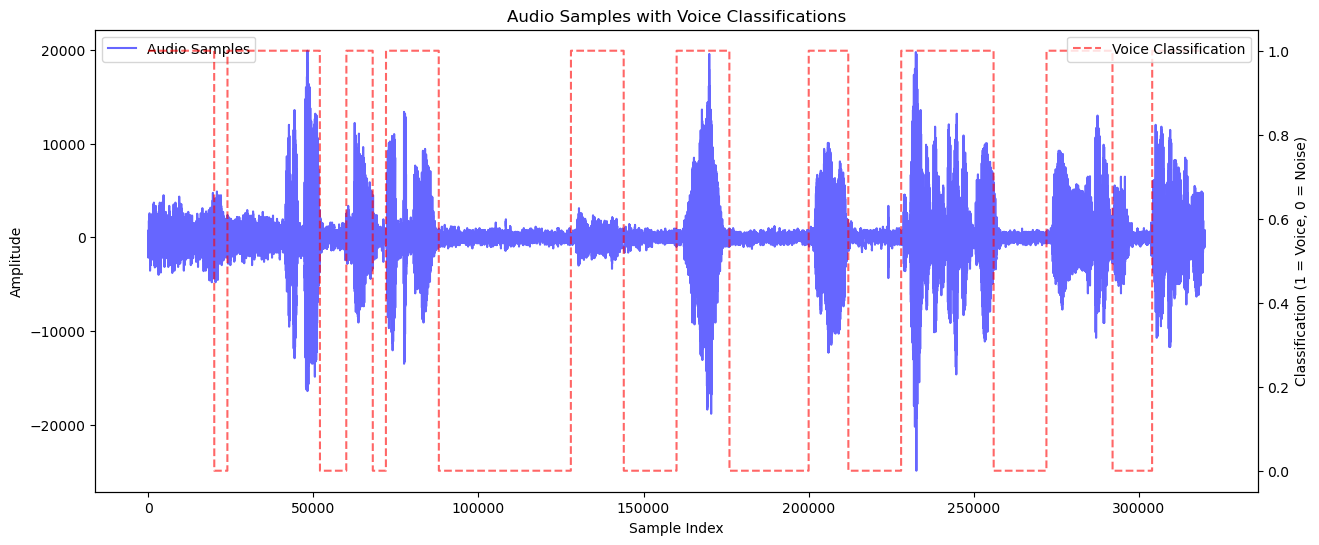

In [144]:
def plot_audio_with_classifications(stg_audio_data, trans_audio_features):
    """
    Plots the concatenated audio samples with voice classifications on a secondary y-axis.

    Parameters:
        stg_audio_data (pd.DataFrame): DataFrame containing `frame_id` and `audio_samples`.
        trans_audio_features (pd.DataFrame): DataFrame containing `frame_id` and `classification`.
    """
    # Concatenate all audio samples into a single array
    concatenated_samples = []
    for samples in stg_audio_data["audio_samples"]:
        concatenated_samples.extend(samples)

    # Prepare the classifications to align with the concatenated audio
    classifications = []
    for frame_id in stg_audio_data["frame_id"]:
        # Get classification for the frame from trans_audio_features
        classification = trans_audio_features.loc[
            trans_audio_features["frame_id"] == frame_id, "classification"
        ].values
        if len(classification) > 0:
            classifications.append(1 if classification[0] == "Voice" else 0)
        else:
            classifications.append(0)  # Default to 0 if no classification

    # Expand classifications to match the length of the audio samples for each frame
    samples_per_frame = [len(samples) for samples in stg_audio_data["audio_samples"]]
    expanded_classifications = []
    for i, samples_count in enumerate(samples_per_frame):
        expanded_classifications.extend([classifications[i]] * samples_count)

    # Plot the audio samples
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax1.plot(concatenated_samples, label="Audio Samples", color="blue", alpha=0.6)
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc="upper left")

    # Plot classifications on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(expanded_classifications, label="Voice Classification", color="red", alpha=0.6, linestyle="--")
    ax2.set_ylabel("Classification (1 = Voice, 0 = Noise)")
    ax2.legend(loc="upper right")

    plt.title("Audio Samples with Voice Classifications")
    plt.show()

# Usage example:
plot_audio_with_classifications(stg_audio_data, trans_audio_features)

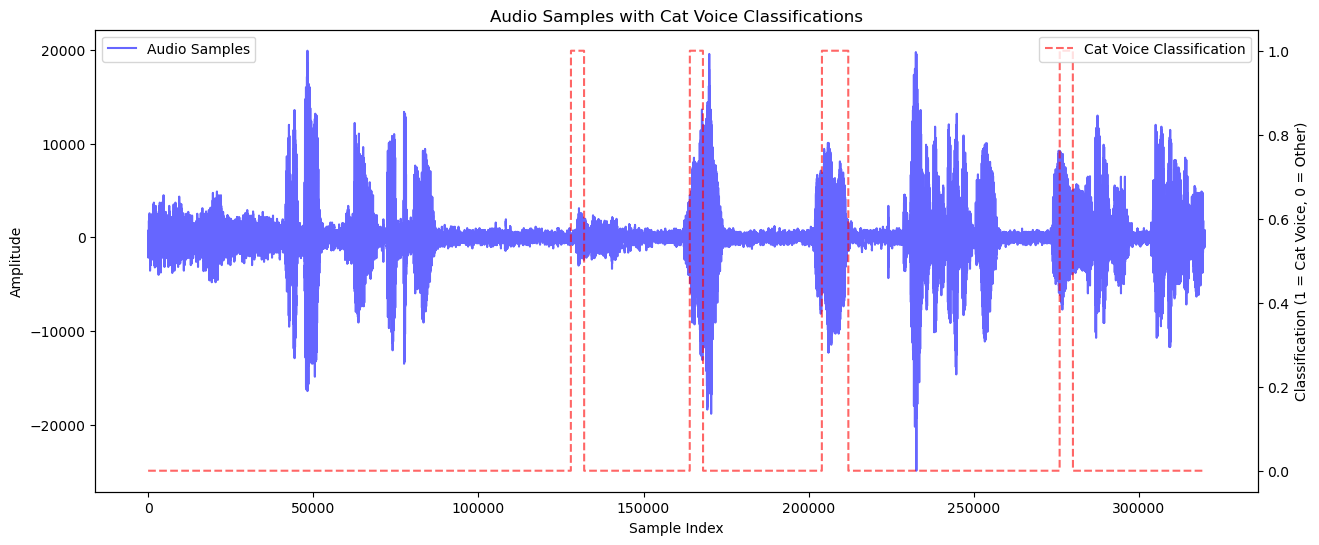

In [145]:
def plot_audio_with_cat_voice(stg_audio_data, trans_audio_features):
    """
    Plots the concatenated audio samples with cat voice classifications on a secondary y-axis.

    Parameters:
        stg_audio_data (pd.DataFrame): DataFrame containing `frame_id` and `audio_samples`.
        trans_audio_features (pd.DataFrame): DataFrame containing `frame_id` and `is_cat_voice`.
    """
    # Concatenate all audio samples into a single array
    concatenated_samples = []
    for samples in stg_audio_data["audio_samples"]:
        concatenated_samples.extend(samples)

    # Prepare the is_cat_voice values to align with the concatenated audio
    cat_voice_flags = []
    for frame_id in stg_audio_data["frame_id"]:
        # Get is_cat_voice for the frame from trans_audio_features
        is_cat_voice = trans_audio_features.loc[
            trans_audio_features["frame_id"] == frame_id, "is_cat_voice"
        ].values
        if len(is_cat_voice) > 0:
            cat_voice_flags.append(is_cat_voice[0])
        else:
            cat_voice_flags.append(0)  # Default to 0 if no classification

    # Expand cat voice flags to match the length of the audio samples for each frame
    samples_per_frame = [len(samples) for samples in stg_audio_data["audio_samples"]]
    expanded_cat_voice_flags = []
    for i, samples_count in enumerate(samples_per_frame):
        expanded_cat_voice_flags.extend([cat_voice_flags[i]] * samples_count)

    # Plot the audio samples
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax1.plot(concatenated_samples, label="Audio Samples", color="blue", alpha=0.6)
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc="upper left")

    # Plot cat voice classifications on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(expanded_cat_voice_flags, label="Cat Voice Classification", color="red", alpha=0.6, linestyle="--")
    ax2.set_ylabel("Classification (1 = Cat Voice, 0 = Other)")
    ax2.legend(loc="upper right")

    plt.title("Audio Samples with Cat Voice Classifications")
    plt.show()

# Usage example:
plot_audio_with_cat_voice(stg_audio_data, trans_audio_features)

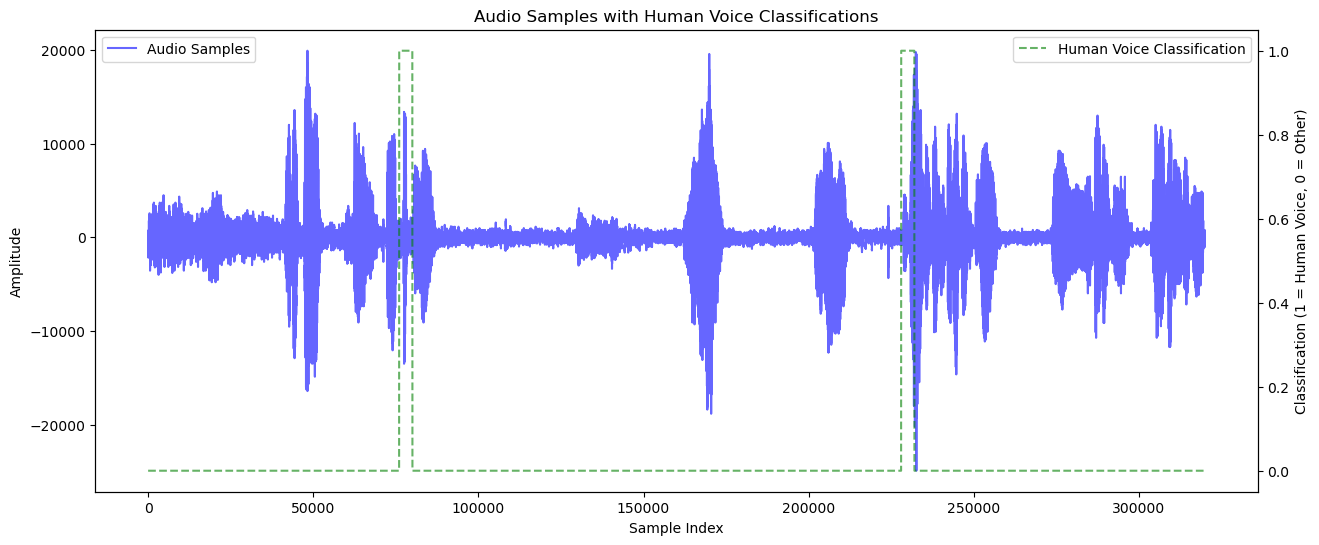

In [146]:
def plot_audio_with_human_voice(stg_audio_data, trans_audio_features):
    """
    Plots the concatenated audio samples with human voice classifications on a secondary y-axis.

    Parameters:
        stg_audio_data (pd.DataFrame): DataFrame containing `frame_id` and `audio_samples`.
        trans_audio_features (pd.DataFrame): DataFrame containing `frame_id` and `is_human_voice`.
    """
    # Concatenate all audio samples into a single array
    concatenated_samples = []
    for samples in stg_audio_data["audio_samples"]:
        concatenated_samples.extend(samples)

    # Prepare the is_human_voice values to align with the concatenated audio
    human_voice_flags = []
    for frame_id in stg_audio_data["frame_id"]:
        # Get is_human_voice for the frame from trans_audio_features
        is_human_voice = trans_audio_features.loc[
            trans_audio_features["frame_id"] == frame_id, "is_human_voice"
        ].values
        if len(is_human_voice) > 0:
            human_voice_flags.append(is_human_voice[0])
        else:
            human_voice_flags.append(0)  # Default to 0 if no classification

    # Expand human voice flags to match the length of the audio samples for each frame
    samples_per_frame = [len(samples) for samples in stg_audio_data["audio_samples"]]
    expanded_human_voice_flags = []
    for i, samples_count in enumerate(samples_per_frame):
        expanded_human_voice_flags.extend([human_voice_flags[i]] * samples_count)

    # Plot the audio samples
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax1.plot(concatenated_samples, label="Audio Samples", color="blue", alpha=0.6)
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc="upper left")

    # Plot human voice classifications on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(expanded_human_voice_flags, label="Human Voice Classification", color="green", alpha=0.6, linestyle="--")
    ax2.set_ylabel("Classification (1 = Human Voice, 0 = Other)")
    ax2.legend(loc="upper right")

    plt.title("Audio Samples with Human Voice Classifications")
    plt.show()

# Usage example:
plot_audio_with_human_voice(stg_audio_data, trans_audio_features)

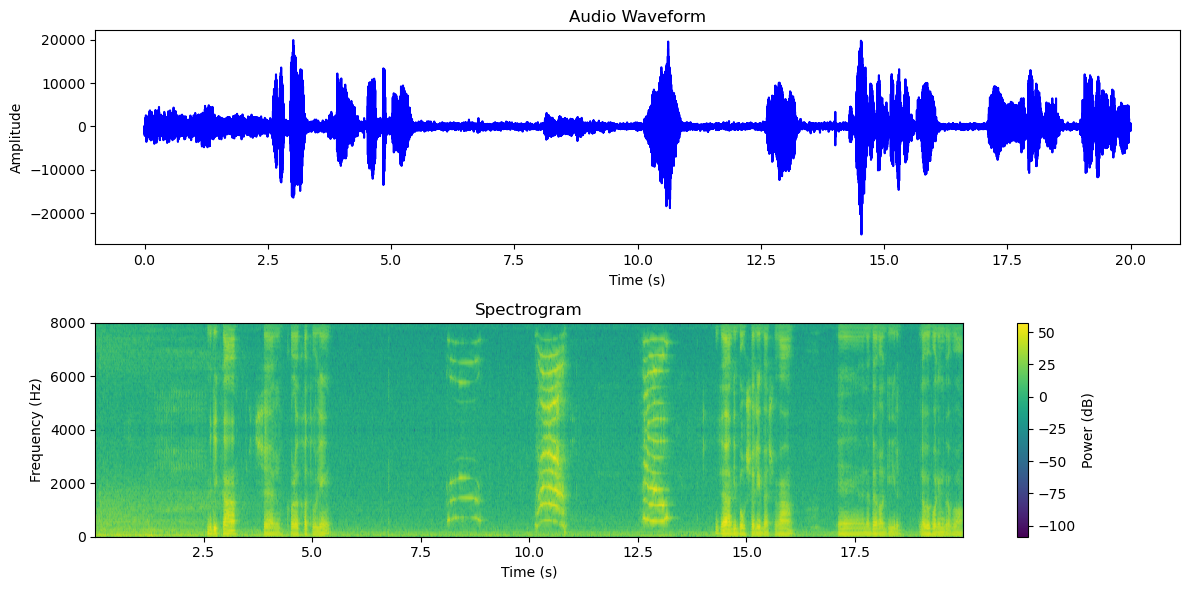

In [147]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import numpy as np

# Function to plot waveform and spectrogram
def plot_waveform_and_spectrogram(stg_audio_data, sampling_rate=16000):
    """
    Plots the concatenated audio waveform and its spectrogram.

    Parameters:
        stg_audio_data (pd.DataFrame): DataFrame containing 'audio_samples' column as lists of audio samples.
        sampling_rate (int): Sampling rate of the audio in Hz. Default is 16000 Hz.
    """
    # Concatenate all audio samples from all frames
    concatenated_audio = np.concatenate(stg_audio_data["audio_samples"].values)

    # Create a time array for the waveform
    time = np.linspace(0, len(concatenated_audio) / sampling_rate, len(concatenated_audio))

    # Create the spectrogram
    f, t, Sxx = spectrogram(concatenated_audio, fs=sampling_rate)

    # Plot the waveform
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, concatenated_audio, color='blue')
    plt.title("Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Plot the spectrogram
    plt.subplot(2, 1, 2)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label="Power (dB)")
    plt.title("Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()

# Assuming stg_audio_data is already loaded and contains the 'audio_samples' column
plot_waveform_and_spectrogram(stg_audio_data, sampling_rate=16000)

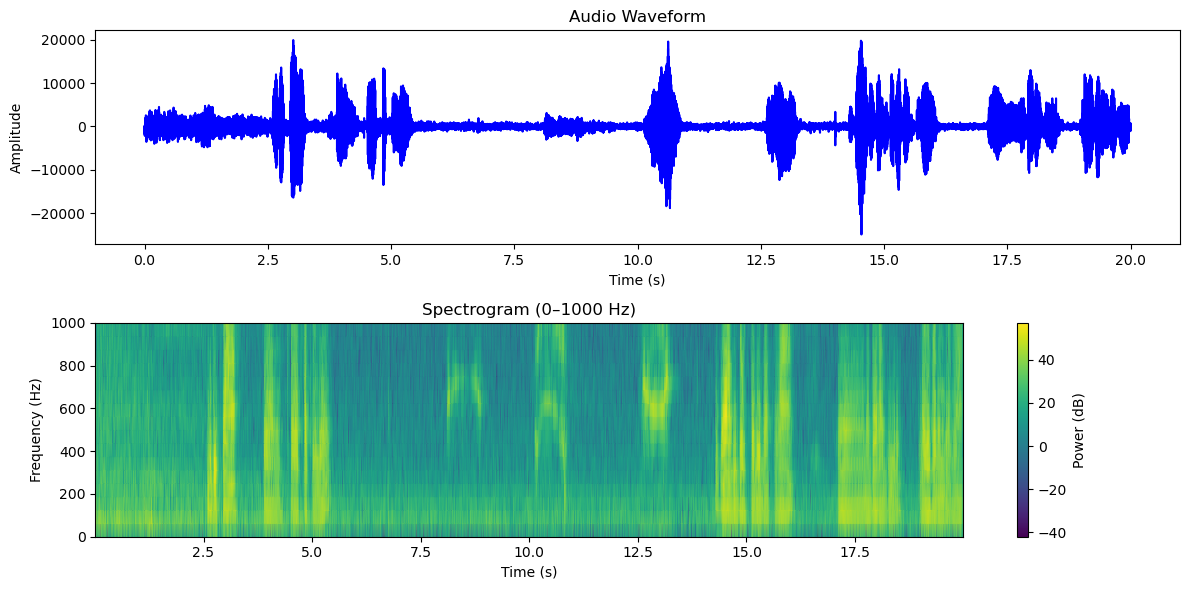

In [148]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import numpy as np

# Function to plot waveform and zoomed-in spectrogram (0–1000 Hz)
def plot_waveform_and_zoomed_spectrogram(stg_audio_data, sampling_rate=16000):
    """
    Plots the concatenated audio waveform and its spectrogram, zoomed in to 0–1000 Hz.

    Parameters:
        stg_audio_data (pd.DataFrame): DataFrame containing 'audio_samples' column as lists of audio samples.
        sampling_rate (int): Sampling rate of the audio in Hz. Default is 16000 Hz.
    """
    # Concatenate all audio samples from all frames
    concatenated_audio = np.concatenate(stg_audio_data["audio_samples"].values)

    # Create a time array for the waveform
    time = np.linspace(0, len(concatenated_audio) / sampling_rate, len(concatenated_audio))

    # Create the spectrogram
    f, t, Sxx = spectrogram(concatenated_audio, fs=sampling_rate)

    # Filter for frequencies up to 1000 Hz
    freq_limit = 1000
    freq_mask = f <= freq_limit
    f_zoomed = f[freq_mask]
    Sxx_zoomed = Sxx[freq_mask, :]

    # Plot the waveform
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, concatenated_audio, color='blue')
    plt.title("Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Plot the spectrogram zoomed in to 0–1000 Hz
    plt.subplot(2, 1, 2)
    plt.pcolormesh(t, f_zoomed, 10 * np.log10(Sxx_zoomed + 1e-10), shading='gouraud')
    plt.colorbar(label="Power (dB)")
    plt.title("Spectrogram (0–1000 Hz)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()

# Assuming stg_audio_data is already loaded and contains the 'audio_samples' column
plot_waveform_and_zoomed_spectrogram(stg_audio_data, sampling_rate=16000)

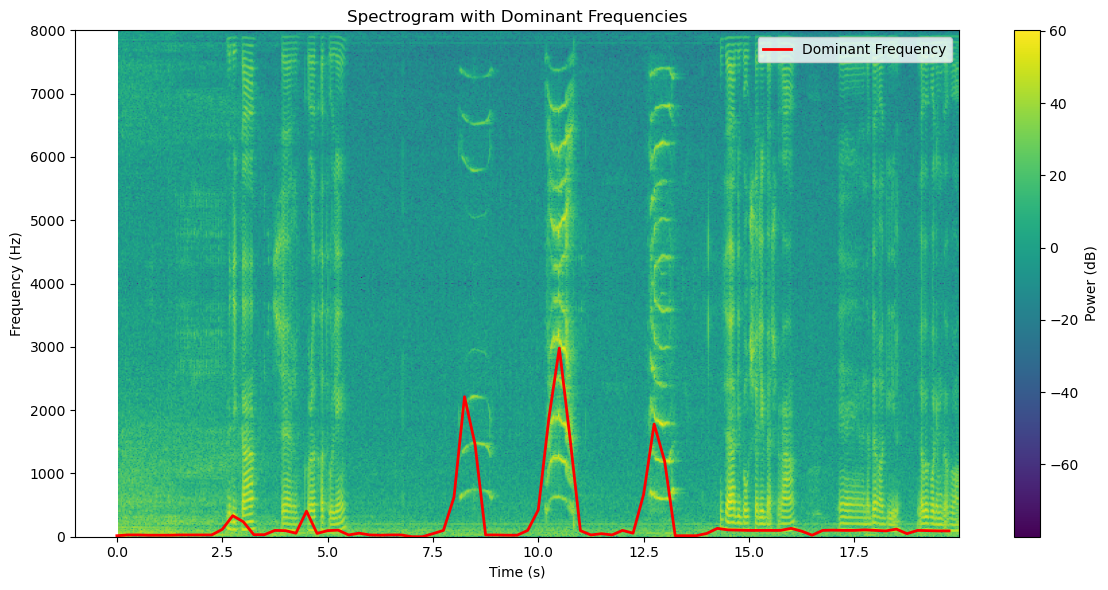

In [151]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming trans_audio_features and stg_audio_data are already defined
# Extract necessary data
audio_samples = np.concatenate(stg_audio_data["audio_samples"].values)
timestamps = np.cumsum([0] + [len(samples) for samples in stg_audio_data["audio_samples"].values[:-1]]) / 16000  # Convert to seconds
dominant_frequencies = trans_audio_features["dominant_frequency"]

# Create the spectrogram
sampling_rate = 16000  # Assuming audio is sampled at 8 kHz
plt.figure(figsize=(12, 6))
plt.specgram(audio_samples, Fs=sampling_rate, NFFT=1024, noverlap=512, cmap="viridis")
plt.colorbar(label="Power (dB)")
plt.title("Spectrogram with Dominant Frequencies")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

# Align dominant_frequencies with timestamps
dominant_timestamps = timestamps  # One timestamp per frame
plt.plot(dominant_timestamps, dominant_frequencies, color="red", label="Dominant Frequency", linewidth=2)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## IMU 

In [17]:
stg_imu_data = pd.read_csv("stg_imu_data.csv")

In [18]:
# Convert samples column from string to list
stg_imu_data['yaw'] = stg_imu_data['yaw'].apply(ast.literal_eval)
stg_imu_data['pitch'] = stg_imu_data['pitch'].apply(ast.literal_eval)
stg_imu_data['roll'] = stg_imu_data['roll'].apply(ast.literal_eval)

In [19]:
stg_imu_data

,frame_id,timestamp,yaw,pitch,roll
0,0,2025-07-23 11:20:32.905018,"[-0.0, 0.0, 0.02, 0.02, 0.02]","[0.09, -0.11, 0.07, 0.45, 0.12]","[0.05, -0.35, 0.06, -0.21, 0.1]"
1,1,2025-07-23 11:20:33.111430,"[0.02, 0.01, 0.02, 0.03, 0.04]","[0.27, 0.0, 0.46, 0.01, 0.33]","[-0.33, 0.05, 0.04, 0.1, -0.23]"
2,2,2025-07-23 11:20:33.324075,"[0.04, 0.03, 0.03, 0.03, 0.03]","[-0.11, 0.21, -0.07, -0.08, -0.44]","[-0.34, -0.01, -0.37, 0.08, -0.22]"
3,3,2025-07-23 11:20:33.540590,"[0.02, 0.01, 0.01, 0.01, -0.0]","[0.02, -0.08, -0.1, 0.29, -0.01]","[-0.24, 0.2, -0.25, -0.01, 0.35]"
4,4,2025-07-23 11:20:33.754385,"[0.01, 0.01, 0.02, 0.02, 0.02]","[0.06, -0.22, -0.03, -0.17, -0.22]","[-0.1, 0.25, -0.16, 0.27, -0.18]"
5,5,2025-07-23 11:20:33.971796,"[0.03, 0.03, 0.03, 0.03, 0.03]","[0.12, -0.26, 0.15, -0.31, -0.02]","[0.13, -0.12, 0.07, 0.09, -0.26]"
6,6,2025-07-23 11:20:34.188188,"[0.03, 0.03, 0.02, 0.01, -0.0]","[0.11, 0.22, -0.07, -0.04, -0.1]","[0.17, -0.28, 0.06, -0.4, 0.05]"
7,7,2025-07-23 11:20:34.403828,"[-0.01, 0.0, -0.0, -0.0, -0.01]","[0.21, -0.05, -0.15, 0.01, 0.28]","[-0.28, 0.11, -0.34, 0.08, -0.29]"
8,8,2025-07-23 11:20:34.616342,"[-0.01, -0.01, -0.01, -0.01, -0.0]","[-0.13, 0.29, 0.01, 0.01, 0.21]","[-0.09, 0.07, -0.3, 0.17, -0.24]"
9,9,2025-07-23 11:20:34.829938,"[0.02, 0.03, 0.04, 0.04, 0.04]","[-0.13, 0.12, -0.17, 0.2, -0.11]","[0.06, -0.32, 0.04, -0.22, 0.11]"


In [20]:
def measure_time(func, *args, **kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    end = time.time()
    return result, end - start

def extract_scalar(x):
    return x[0] if isinstance(x, list) else x

# --- Feature Functions ---

def unwrap_yaw(yaw_list):
    """
    Unwrap the yaw values (in degrees) using numpy.unwrap.
    Returns the unwrapped array.
    """
    arr = np.array(yaw_list, dtype=float)
    return np.degrees(np.unwrap(np.radians(arr)))

def avg_intra_yaw_diff(yaw_list):
    """
    For the given row's yaw (a list), unwrap it, compute the differences
    between consecutive values, and return the average difference.
    """
    unwrapped = unwrap_yaw(yaw_list)
    if len(unwrapped) > 1:
        diffs = np.diff(unwrapped)
        return np.mean(diffs)
    else:
        return 0.0

def compute_rotation_speed(current_yaw_list, prev_avg_yaw):
    """
    Compute rotation speed using only yaw.
      1. Compute the average intra-row yaw difference.
      2. Compute delta_yaw = current_avg - prev_avg (if available).
      3. Return absolute delta_yaw as the rotation speed, along with current_avg and raw delta.
    """
    current_avg = avg_intra_yaw_diff(current_yaw_list)
    if prev_avg_yaw is None:
        delta_yaw = 0.0
    else:
        delta_yaw = current_avg - prev_avg_yaw
    rotation_speed = abs(delta_yaw)
    return rotation_speed, current_avg, delta_yaw

def compute_movement_intensity(delta_yaw, delta_pitch, delta_roll):
    """
    Compute movement intensity as the Euclidean norm of (delta_yaw, delta_pitch, delta_roll).
    """
    return np.sqrt(delta_yaw**2 + delta_pitch**2 + delta_roll**2)

def compute_balance_state(pitch, roll, movement_intensity):
    """
    The robot is balanced if pitch and roll are within ±15° and movement_intensity is low (< 0.3).
    """
    return (abs(pitch) < 15) and (abs(roll) < 15) and (movement_intensity < 0.3)

def compute_cat_interaction(movement_intensity):
    """
    Flag a cat interaction if movement_intensity exceeds a certain value.
    """
    return abs(movement_intensity) > 10

def compute_is_rest(movement_intensity):
    """
    Mark as rest if movement_intensity is very low (< 1).
    """
    return movement_intensity < 1

In [21]:
# --- Live Processing Functions ---

def process_frame(row, state):
    """
    Process one IMU frame (one row) in live mode.
    Uses only previous frame values (stored in state) to compute differences.
    Each feature is computed by its own function.
    Returns a dict with all computed features.
    """
    # --- Rotation Speed (yaw only) ---
    rotation_speed, current_avg_yaw, delta_yaw = compute_rotation_speed(row['yaw'], state.get('prev_avg_yaw'))
    
    # --- Pitch and Roll differences ---
    # For pitch and roll, we assume they are already extracted as scalars.
    pitch = row['pitch']
    roll  = row['roll']
    if state.get('prev_pitch') is None:
        delta_pitch = 0.0
    else:
        delta_pitch = pitch - state['prev_pitch']
    if state.get('prev_roll') is None:
        delta_roll = 0.0
    else:
        delta_roll = roll - state['prev_roll']
    
    # --- Movement Intensity ---
    movement_intensity = compute_movement_intensity(delta_yaw, delta_pitch, delta_roll)
    
    # --- Balance State ---
    balance_state = compute_balance_state(pitch, roll, movement_intensity)
    
    # --- Cat Interaction ---
    cat_interaction_detected = compute_cat_interaction(movement_intensity)
    
    # --- is_rest Feature ---
    is_rest = compute_is_rest(movement_intensity)
    
    # --- Update state for live processing ---
    state['prev_avg_yaw'] = current_avg_yaw
    state['prev_pitch'] = pitch
    state['prev_roll'] = roll
    
    return {
        'frame_id': row['frame_id'],
        'timestamp': row['timestamp'],
        'rotation_speed': rotation_speed,
        'movement_intensity': movement_intensity,
        'balance_state': balance_state,
        'cat_interaction_detected': cat_interaction_detected,
        'is_rest': is_rest,
        # Optionally, include deltas for debugging/tuning:
        'delta_yaw': delta_yaw,
        'delta_pitch': delta_pitch,
        'delta_roll': delta_roll
    }

def process_imu_live(imu_df):
    """
    Process the entire IMU DataFrame row by row (live data simulation)
    and return a transformed table with computed features.
    """
    state = {'prev_avg_yaw': None, 'prev_pitch': None, 'prev_roll': None}
    results = []
    for _, row in imu_df.iterrows():
        features = process_frame(row, state)
        results.append(features)
    return pd.DataFrame(results)

In [22]:
# --- Main Processing Cell ---

# Prepare and clean IMU data.
# (Assumes your pre-cells have done the following:
# 1. stg_imu_data = pd.read_csv("stg_imu_data.csv")
# 2. Converting 'yaw', 'pitch', 'roll' from string to list.
# 3. For pitch and roll, extracting the first element; leave yaw as the full list.)
imu_df = stg_imu_data[['frame_id', 'timestamp', 'yaw', 'pitch', 'roll']].copy()
imu_df['pitch'] = imu_df['pitch'].apply(lambda x: x[0] if isinstance(x, list) else x)
imu_df['roll']  = imu_df['roll'].apply(lambda x: x[0] if isinstance(x, list) else x)
# Do NOT extract yaw (we need the full list for intra-row processing).

# Process the IMU data live and obtain the mart table.
trans_imu_features = process_imu_live(imu_df)

# Optionally, inspect the transformed table.
print(trans_imu_features.describe())

        frame_id  rotation_speed  movement_intensity     delta_yaw  \
count  94.000000       94.000000           94.000000  9.400000e+01   
mean   46.500000        0.635532            1.564530 -5.319149e-05   
std    27.279418        1.092858            1.594161  1.265932e+00   
min     0.000000        0.000000            0.000000 -4.265000e+00   
25%    23.250000        0.005625            0.434209 -1.018750e-01   
50%    46.500000        0.096250            0.865987  1.734723e-18   
75%    69.750000        0.730625            2.419009  7.312500e-02   
max    93.000000        5.032500            6.684357  5.032500e+00   

       delta_pitch  delta_roll  
count    94.000000   94.000000  
mean     -0.006277    0.005106  
std       1.229980    1.378376  
min      -3.060000   -3.140000  
25%      -0.395000   -0.515000  
50%       0.020000    0.000000  
75%       0.307500    0.367500  
max       4.980000    5.110000  


In [23]:
trans_imu_features

,frame_id,timestamp,rotation_speed,movement_intensity,balance_state,cat_interaction_detected,is_rest,delta_yaw,delta_pitch,delta_roll
0,0,2025-07-23 11:20:32.905018,0.000000e+00,0.000000,True,False,True,0.000000e+00,0.00,0.00
1,1,2025-07-23 11:20:33.111430,0.000000e+00,0.420476,False,False,True,0.000000e+00,0.18,-0.38
2,2,2025-07-23 11:20:33.324075,7.500000e-03,0.380206,False,False,True,-7.500000e-03,-0.38,-0.01
3,3,2025-07-23 11:20:33.540590,2.500000e-03,0.164031,True,False,True,-2.500000e-03,0.13,0.10
4,4,2025-07-23 11:20:33.754385,7.500000e-03,0.145795,True,False,True,7.500000e-03,0.04,0.14
5,5,2025-07-23 11:20:33.971796,2.500000e-03,0.237710,True,False,True,-2.500000e-03,0.06,0.23
6,6,2025-07-23 11:20:34.188188,7.500000e-03,0.041908,True,False,True,-7.500000e-03,-0.01,0.04
7,7,2025-07-23 11:20:34.403828,7.500000e-03,0.461038,False,False,True,7.500000e-03,0.10,-0.45
8,8,2025-07-23 11:20:34.616342,2.500000e-03,0.389495,False,False,True,2.500000e-03,-0.34,0.19
9,9,2025-07-23 11:20:34.829938,2.500000e-03,0.150021,True,False,True,2.500000e-03,0.00,0.15


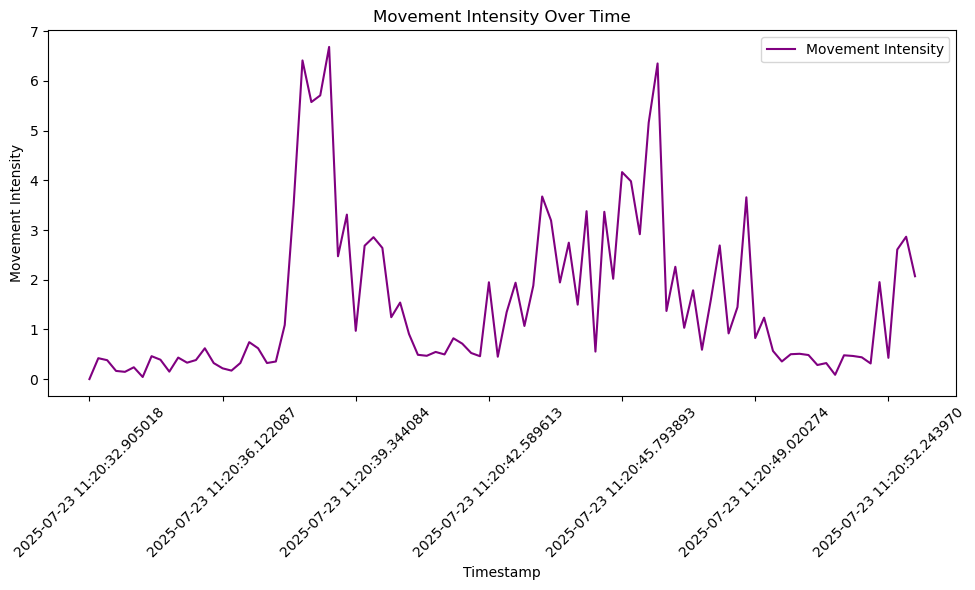

In [24]:


plt.figure(figsize=(10, 6))
plt.plot(trans_imu_features['timestamp'], trans_imu_features['movement_intensity'],
         label='Movement Intensity', color='purple')
plt.title('Movement Intensity Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Movement Intensity')
plt.legend()

# Rotate timestamps to avoid overlap
plt.xticks(rotation=45)

# Optionally limit the number of x-axis ticks to reduce clutter
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(10))

plt.tight_layout()
plt.show()

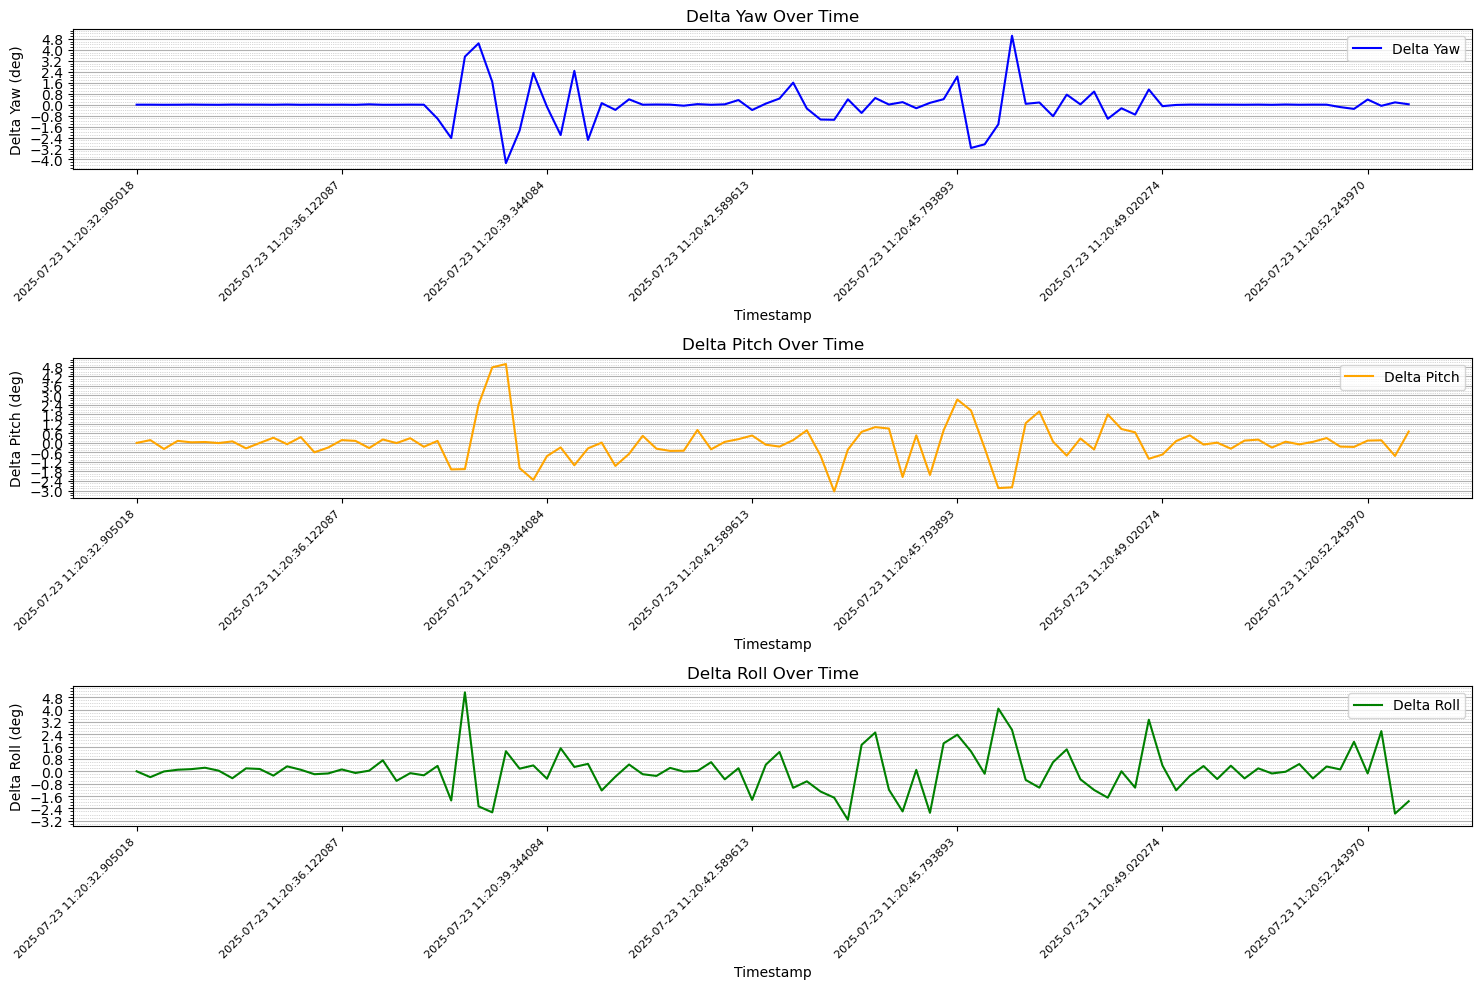

In [25]:
plt.figure(figsize=(15, 10))

# --- Subplot 1: Delta Yaw ---
ax1 = plt.subplot(3, 1, 1)
ax1.plot(trans_imu_features['timestamp'], trans_imu_features['delta_yaw'], 
         label='Delta Yaw', color='blue')
ax1.set_title('Delta Yaw Over Time')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Delta Yaw (deg)')
ax1.legend()

# Increase the number of major ticks on Y
ax1.yaxis.set_major_locator(ticker.MaxNLocator(15))
# Enable minor ticks automatically
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
# Show grid lines for both major and minor ticks
ax1.grid(which='major', axis='y', linewidth=0.8)
ax1.grid(which='minor', axis='y', linestyle=':', linewidth=0.5)

# Limit the number of X ticks to reduce clutter
ax1.xaxis.set_major_locator(ticker.MaxNLocator(10))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=8)

# --- Subplot 2: Delta Pitch ---
ax2 = plt.subplot(3, 1, 2)
ax2.plot(trans_imu_features['timestamp'], trans_imu_features['delta_pitch'], 
         label='Delta Pitch', color='orange')
ax2.set_title('Delta Pitch Over Time')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Delta Pitch (deg)')
ax2.legend()

ax2.yaxis.set_major_locator(ticker.MaxNLocator(15))
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.grid(which='major', axis='y', linewidth=0.8)
ax2.grid(which='minor', axis='y', linestyle=':', linewidth=0.5)

ax2.xaxis.set_major_locator(ticker.MaxNLocator(10))
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=8)

# --- Subplot 3: Delta Roll ---
ax3 = plt.subplot(3, 1, 3)
ax3.plot(trans_imu_features['timestamp'], trans_imu_features['delta_roll'], 
         label='Delta Roll', color='green')
ax3.set_title('Delta Roll Over Time')
ax3.set_xlabel('Timestamp')
ax3.set_ylabel('Delta Roll (deg)')
ax3.legend()

ax3.yaxis.set_major_locator(ticker.MaxNLocator(15))
ax3.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax3.grid(which='major', axis='y', linewidth=0.8)
ax3.grid(which='minor', axis='y', linestyle=':', linewidth=0.5)

ax3.xaxis.set_major_locator(ticker.MaxNLocator(10))
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.show()

# Video Transformations

In [26]:
# 📦 Cell – MP4 ➜ CSV  (frame_id, timestamp, frame_data = **JPEG-compressed RGB**)
# ─────────────────────────────────────────────────────────────────────────────
"""
Drop this cell into your notebook, edit VIDEO_PATH / OUTPUT_CSV, run – done.
The resulting CSV matches the **compressed-JPEG** format we switched to
(`frame_data` is a base-64-encoded .jpg *per frame*, not raw bytes).
"""

import cv2, base64, numpy as np, pandas as pd
from pathlib import Path

# ─── user settings ──────────────────────────────────────────────────────────
VIDEO_PATH = "640_test.mp4"     # ← your source .mp4
OUTPUT_CSV = "640_test.csv"     # ← will be (over-)written
IMG_SIZE   = 640                # every frame resized to 640 × 640 (keep ≥96 for YOLO)
JPEG_QUALITY = 85               # 1–100 (higher = larger file, better quality)

# ─── open video -------------------------------------------------------------
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"❌ Cannot open {VIDEO_PATH}")

fps       = cap.get(cv2.CAP_PROP_FPS) or 30   # some phones leave FPS undefined
rows      = []
frame_idx = 0

# ─── iterate frames ---------------------------------------------------------
while True:
    ok, bgr = cap.read()
    if not ok:
        break

    # BGR → RGB → resize
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    if rgb.shape[:2] != (IMG_SIZE, IMG_SIZE):
        rgb = cv2.resize(rgb, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)

    # JPEG-encode in memory  (OpenCV expects BGR, so flip back)
    ok_, jpg_bytes = cv2.imencode(".jpg",
                                  cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR),
                                  [int(cv2.IMWRITE_JPEG_QUALITY), JPEG_QUALITY])
    if not ok_:
        raise RuntimeError("❌ OpenCV .imencode failed")

    b64 = base64.b64encode(jpg_bytes).decode("ascii")

    rows.append((frame_idx, round(frame_idx / fps, 5), b64))
    frame_idx += 1

cap.release()

# ─── save CSV ---------------------------------------------------------------
df = pd.DataFrame(rows, columns=["frame_id", "timestamp", "frame_data"])
df.to_csv(OUTPUT_CSV, index=False)

print(f"✅  Saved {len(df):,} frames → {Path(OUTPUT_CSV).resolve()}")
df.head()        # quick peek

✅  Saved 862 frames → /Users/asaphbrosh/Documents/Projects/Logots/trf/640_test.csv


,frame_id,timestamp,frame_data
0,0,0.00000,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUDBAQEAwUEBA...
1,1,0.03333,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUDBAQEAwUEBA...
2,2,0.06667,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUDBAQEAwUEBA...
3,3,0.10000,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUDBAQEAwUEBA...
4,4,0.13333,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUDBAQEAwUEBA...


In [27]:
# ───────────────────────── Cell 1 – imports & constants ─────────────────────
import io, time, base64, os, urllib.request, json, warnings
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image, ImageDraw
import cv2, torch                                # OpenCV + PyTorch
from ultralytics import YOLO                    # pip install ultralytics>=8.1

# ---------------- USER-EDITABLE ------------------------------------------------
INPUT_CSV   = "stg_visual_data.csv"   # ← JPEG-in-CSV
IMG_SIZE    = 640                    # 96×96 for micro-csv, 640 for full res
CONF_THR    = 0.05                   # low threshold – “cat” only
DEVICE      = "cpu"                  # "cuda" if GPU available
CAT_ID      = 15                     # COCO id for “cat”
# ------------------------------------------------------------------------------

model = YOLO("yolov8n.pt").to(DEVICE)
model.fuse()
model.overrides["conf"]    = CONF_THR
model.overrides["classes"] = [CAT_ID]
print("✅  YOLOv8 nano - cat-only ready")

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
✅  YOLOv8 nano - cat-only ready


In [28]:
def load_staging_csv(path: str) -> pd.DataFrame:
    """Read CSV exactly as stored by ESP-32 side (frame_id INT, ts ANY, frame_data STR)."""
    return pd.read_csv(path, converters={"frame_data": str})

stg_video_data = load_staging_csv(INPUT_CSV)
print(f"✅  loaded {len(stg_video_data)} frames from {INPUT_CSV}")

✅  loaded 82 frames from stg_visual_data.csv


In [29]:
stg_video_data.head()

,frame_id,timestamp,frame_data
0,0,2025-07-23 11:20:33.288155,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...
1,1,2025-07-23 11:20:33.531604,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...
2,2,2025-07-23 11:20:33.755833,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...
3,3,2025-07-23 11:20:33.992241,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...
4,4,2025-07-23 11:20:34.212651,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...


In [30]:
def jpeg_b64_to_rgb_ndarray(b64: str, img_size: int) -> np.ndarray:
    """base-64 JPEG ➜ RGB numpy (H,W,3)  resized to img_size."""
    with Image.open(io.BytesIO(base64.b64decode(b64))) as im:
        im = im.convert("RGB").resize((img_size, img_size), Image.LANCZOS)
        return np.array(im, dtype=np.uint8)

def rgb_ndarray_to_jpeg_b64(arr: np.ndarray, *, quality: int = 85) -> str:
    """Helper if you ever need to STORE frames in the new format."""
    buff = io.BytesIO()
    Image.fromarray(arr, mode="RGB").save(buff, format="JPEG", quality=quality)
    return base64.b64encode(buff.getvalue()).decode("ascii")

In [31]:
def detect_cat(df: pd.DataFrame, img_size: int) -> pd.DataFrame:
    rows, t0_all = [], time.time()

    for _, r in df.iterrows():
        rgb = jpeg_b64_to_rgb_ndarray(r["frame_data"], img_size)
        pil = Image.fromarray(rgb)
        t0  = time.time()
        res = model(pil, imgsz=img_size, verbose=False)[0]
        dt  = time.time() - t0

        boxes = res.boxes.cpu()
        det_pd = pd.DataFrame({
            "xmin"      : boxes.xyxy[:, 0].numpy(),
            "ymin"      : boxes.xyxy[:, 1].numpy(),
            "xmax"      : boxes.xyxy[:, 2].numpy(),
            "ymax"      : boxes.xyxy[:, 3].numpy(),
            "confidence": boxes.conf.numpy(),
            "class"     : boxes.cls.numpy().astype(int),
            "name"      : ["cat"]*len(boxes),          # only cat requested
        })

        cats = det_pd                              # all dets are cats anyway
        rows.append({
            "frame_id"        : int(r["frame_id"]),
            "timestamp"       : r["timestamp"],
            "is_cat_detected" : int(len(cats) > 0),
            "cat_confidence"  : float(cats["confidence"].max()) if len(cats) else 0.0,
            "inference_time"  : dt,
            "raw_detection"   : det_pd.to_dict("records"),
        })

    n = len(df)
    print(f"✅  processed {n} frames @ {n/(time.time()-t0_all):.1f} FPS")
    return pd.DataFrame(rows)

trans_visual_cat_detection = detect_cat(stg_video_data, IMG_SIZE)

✅  processed 82 frames @ 9.6 FPS


In [32]:
trans_visual_cat_detection

,frame_id,timestamp,is_cat_detected,cat_confidence,inference_time,raw_detection
0,0,2025-07-23 11:20:33.288155,0,0.000000,0.640755,[]
1,1,2025-07-23 11:20:33.531604,0,0.000000,0.093004,[]
2,2,2025-07-23 11:20:33.755833,0,0.000000,0.091779,[]
3,3,2025-07-23 11:20:33.992241,0,0.000000,0.091663,[]
4,4,2025-07-23 11:20:34.212651,0,0.000000,0.093318,[]
5,5,2025-07-23 11:20:34.437017,0,0.000000,0.091783,[]
6,6,2025-07-23 11:20:34.670112,0,0.000000,0.095138,[]
7,7,2025-07-23 11:20:34.890766,0,0.000000,0.097469,[]
8,8,2025-07-23 11:20:35.115381,0,0.000000,0.094091,[]
9,9,2025-07-23 11:20:35.351572,0,0.000000,0.096950,[]


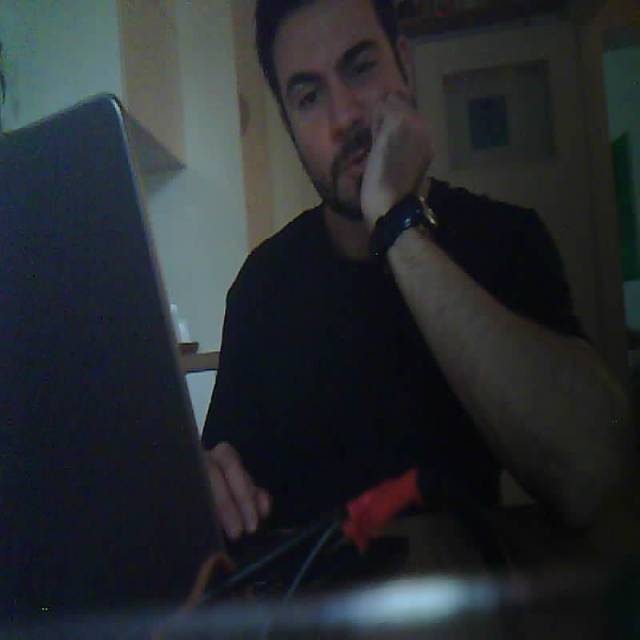

In [33]:
def draw_boxes_on_frame(frame_row, det_row, img_size: int) -> Image.Image:
    rgb = jpeg_b64_to_rgb_ndarray(frame_row.frame_data, img_size)
    img = Image.fromarray(rgb)
    draw = ImageDraw.Draw(img)
    for b in det_row.raw_detection:
        draw.rectangle([b["xmin"], b["ymin"], b["xmax"], b["ymax"]],
                       outline="red", width=2)
        draw.text((b["xmin"], max(0, b["ymin"]-12)),
                  f'{b["name"]} {b["confidence"]:.2f}', fill="red")
    return img

# quick preview (frame 0)
display(draw_boxes_on_frame(stg_video_data.iloc[80],
                            trans_visual_cat_detection.iloc[80],
                            IMG_SIZE))

In [34]:
# ──────────────── FIXED Cell 6 – robust annotated-video writer ────────────────
import cv2, numpy as np
from pathlib import Path
from datetime import datetime as _dt

def _infer_fps(ts_col) -> float:
    """
    Accepts   • numeric seconds OR
              • any string that `pd.to_datetime` understands.
    Returns median frame-rate (defaults to 20 if <2 frames).
    """
    if np.issubdtype(ts_col.dtype, np.number):
        secs = ts_col.astype(float).values
    else:                                                     # string / datetime
        secs = pd.to_datetime(ts_col, errors="coerce").astype("int64") / 1e9
    if len(secs) < 2 or np.allclose(secs, secs[0]):
        return 20.0
    return 1.0 / np.median(np.diff(secs))

def save_annotated_video(
    stg_df      : pd.DataFrame,
    det_df      : pd.DataFrame,
    img_size    : int,
    out_path    : str = "annotated_cat_video",
    fps         : float | None = None,
    prefer_mp4  : bool = True,
):
    # ─── fps ────────────────────────────────────────────────────────────────
    fps = fps or _infer_fps(stg_df["timestamp"])
    # ─── first frame ⇒ size -------------------------------------------------
    first_img = draw_boxes_on_frame(stg_df.iloc[0], det_df.iloc[0], img_size)
    h, w = first_img.height, first_img.width
    # ─── codec --------------------------------------------------------------
    fourcc = cv2.VideoWriter_fourcc(*("mp4v" if prefer_mp4 else "XVID"))
    ext    = ".mp4" if prefer_mp4 else ".avi"
    writer = cv2.VideoWriter(str(Path(out_path).with_suffix(ext)), fourcc, fps, (w, h))
    if not writer.isOpened():
        raise RuntimeError("⚠️ OpenCV could not open a writer – try prefer_mp4=False")
    # ─── write frames -------------------------------------------------------
    for fid in det_df.sort_values("frame_id").frame_id:
        frow = stg_df.loc[stg_df.frame_id == fid].iloc[0]
        drow = det_df.loc[det_df.frame_id   == fid].iloc[0]
        frame_bgr = cv2.cvtColor(np.asarray(draw_boxes_on_frame(frow, drow, img_size)),
                                 cv2.COLOR_RGB2BGR)
        writer.write(frame_bgr)
    writer.release()
    print(f"✅  saved {Path(out_path).with_suffix(ext).resolve()}  ({fps:.2f} FPS)")

# ─── demo: first 300 frames (change as desired) ───────────────────────────────
save_annotated_video(
    stg_video_data.head(300),
    trans_visual_cat_detection.head(300),
    IMG_SIZE,
    out_path="annotated_cat_video",    # extension added automatically
    fps=None,                          # auto-infer
    prefer_mp4=True                    # set False to force .avi (XVID)
)

✅  saved /Users/asaphbrosh/Documents/Projects/Logots/trf/annotated_cat_video.mp4  (20.00 FPS)


# Mart Transformations

In [35]:
# Save all transformation model structures

# trans_audio_features.head().to_csv('trans_audio_features.csv')
# trans_imu_features.head().to_csv('trans_imu_features.csv')
# trans_visual_cat_detection.head().to_csv('trans_visual_cat_detection.csv')

trans_audio_features.to_csv('trans_audio_features.csv')
trans_imu_features.to_csv('trans_imu_features.csv')
trans_visual_cat_detection.to_csv('trans_visual_cat_detection.csv')

In [40]:
# 📦  Cell — build `mrt_experiences` (robust audio mask fix)
# ---------------------------------------------------------------------
import pandas as pd, numpy as np, ast

# ---------------------------------------------------------------------
# Config
# ---------------------------------------------------------------------
AUDIO_CSV = "trans_audio_features.csv"
IMU_CSV   = "trans_imu_features.csv"
VIS_CSV   = "trans_visual_cat_detection.csv"

N_FRAMES  = 12     # aggregation window
HEAD_ROWS = 100     # quick-test batch size

# ---------------------------------------------------------------------
# Helpers
# ---------------------------------------------------------------------
def _parse_raw_detection(v):
    try:
        return ast.literal_eval(v) if isinstance(v, str) else []
    except Exception:
        return []

def safe_col(df, name, default_dtype):
    """Return column if present, else Series of default values (len=df)."""
    if name in df:
        return df[name]
    return pd.Series([default_dtype()]*len(df), index=df.index, dtype=type(default_dtype()))

def mode_or_nan(series):
    return series.mode().iloc[0] if not series.empty else np.nan

def last_n(df, fid):
    return df[df["frame_id"] <= fid].tail(N_FRAMES)

# ---------------------------------------------------------------------
# Load data (first HEAD_ROWS rows each)
# ---------------------------------------------------------------------
aud_df = pd.read_csv(AUDIO_CSV, nrows=HEAD_ROWS)
imu_df = pd.read_csv(IMU_CSV,   nrows=HEAD_ROWS)
vis_df = pd.read_csv(
    VIS_CSV, nrows=HEAD_ROWS,
    converters={"raw_detection": _parse_raw_detection}
)

# ---------------------------------------------------------------------
# Build mart_experiences
# ---------------------------------------------------------------------
rows = []
for fid in sorted(vis_df["frame_id"].unique()):
    aud = last_n(aud_df, fid)
    imu = last_n(imu_df, fid)
    vis = last_n(vis_df, fid)

    # first N_FRAMES rows => NaNs
    if len(vis) < N_FRAMES:
        rows.append(dict.fromkeys([
            "experience_id", "last_experience_id_array", "timestamp",
            "is_cat_voice", "is_human_voice", "human_voice_sequence",
            "cat_voice_sequence", "meow_loudness",
            "cat_detected", "cat_position_x", "cat_position_y",
            "cat_movement_direction", "cat_activity_level", "cat_distance_change",
            "movement_intensity", "cat_interaction_detected"
        ], np.nan) | {"experience_id": fid})
        continue

    # ---------- Audio aggregates -------------------------------------
    aud_is_cat   = safe_col(aud, "is_cat_voice",   bool).fillna(False).astype(bool)
    aud_is_human = safe_col(aud, "is_human_voice", bool).fillna(False).astype(bool)

    fid_col = "frame_id" if "frame_id" in aud else None
    human_seq = aud.loc[aud_is_human, fid_col].tolist() if fid_col else []
    cat_seq   = aud.loc[aud_is_cat,   fid_col].tolist() if fid_col else []

    meow_loudness = mode_or_nan(safe_col(aud, "meow_loudness", str))

    # ---------- IMU aggregates ---------------------------------------
    movement_intensity = safe_col(imu, "movement_intensity", float).mean()
    cat_interaction    = bool(safe_col(imu, "cat_interaction_detected", bool).any())

    # ---------- Vision aggregates ------------------------------------
    vis_last = vis.iloc[-1]
    cat_detected = any(
        any(d.get("name") == "cat" for d in dets)
        for dets in vis["raw_detection"]
    )

    cat_x = cat_y = prev_x = prev_y = np.nan
    # current frame centroid
    for det in vis_last["raw_detection"]:
        if det.get("name") == "cat":
            cat_x = (det["xmin"] + det["xmax"]) / 2
            cat_y = (det["ymin"] + det["ymax"]) / 2
            break
    # previous frame centroid
    if len(vis) > 1:
        for det in vis.iloc[-2]["raw_detection"]:
            if det.get("name") == "cat":
                prev_x = (det["xmin"] + det["xmax"]) / 2
                prev_y = (det["ymin"] + det["ymax"]) / 2
                break
    dx = cat_x - prev_x if np.isfinite(cat_x) and np.isfinite(prev_x) else 0
    dy = cat_y - prev_y if np.isfinite(cat_y) and np.isfinite(prev_y) else 0

    cat_movement_direction = (
        "left"  if dx < -2 else
        "right" if dx >  2 else
        "towards" if dy < -2 else
        "away"    if dy >  2 else
        "stationary"
    )
    cat_activity_level  = "moving" if max(abs(dx), abs(dy)) > 3 else "still"
    cat_distance_change = (
        "closer"  if dy < -2 else
        "farther" if dy >  2 else
        "no_change"
    )

    # ---------- Assemble row -----------------------------------------
    rows.append(dict(
        experience_id           = fid,
        last_experience_id_array = vis["frame_id"].tolist()[-N_FRAMES:],
        timestamp                = vis_last.get("timestamp", np.nan),
        is_cat_voice             = bool(aud_is_cat.any()),
        is_human_voice           = bool(aud_is_human.any()),
        human_voice_sequence     = human_seq,
        cat_voice_sequence       = cat_seq,
        meow_loudness            = meow_loudness,
        cat_detected             = cat_detected,
        cat_position_x           = cat_x,
        cat_position_y           = cat_y,
        cat_movement_direction   = cat_movement_direction,
        cat_activity_level       = cat_activity_level,
        cat_distance_change      = cat_distance_change,
        movement_intensity       = movement_intensity,
        cat_interaction_detected = cat_interaction
    ))

mrt_experiences = pd.DataFrame(rows)

In [41]:
mrt_experiences

,experience_id,last_experience_id_array,timestamp,is_cat_voice,is_human_voice,human_voice_sequence,cat_voice_sequence,meow_loudness,cat_detected,cat_position_x,cat_position_y,cat_movement_direction,cat_activity_level,cat_distance_change,movement_intensity,cat_interaction_detected
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# tbd
# fix mewo loudness
# change 'still' to 'absent'